In [50]:
# ECE661 HW9
# Zhengxin Jiang
# jiang839

import cv2
import numpy as np
import matplotlib . pyplot as plt
import math
from scipy.optimize import least_squares


# Normalize a set of points
def pointsNormalization(points):
    
    pts = np.append(points, np.ones((len(points),1)), axis=1).T
    
    mu_x = np.mean(pts[0])
    mu_y = np.mean(pts[1])
    mu_dist = np.mean(np.sqrt((pts[0]-mu_x)**2 + (pts[1]-mu_y)**2))
    
    c = np.sqrt(2)/mu_dist
    T = np.array([[c,0,-c*mu_x], [0,c,-c*mu_y], [0,0,1]])
    
    pts_nm = np.dot(T, pts).T
    
    return pts_nm[:, :2], T

# Do the initial fundamental matrix estimation
def initialF(points1, points2, T1, T2):
    
    A = np.zeros((len(points1), 9))
    
    for i in range(len(points1)):
        
        x1 = points1[i][0]
        y1 = points1[i][1]
        x2 = points2[i][0]
        y2 = points2[i][1]
        
        A[i] = [x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1, 1]
        
    _,_,v = np.linalg.svd(A)
    F = np.reshape(v[-1], (3,3))
    
    #conditioning
    u,d,v = np.linalg.svd(F)
    d_ = np.array([[d[0],0,0], [0,d[1],0], [0,0,0]])
    F = np.dot(np.dot(u, d_), v)
    
    
    # denormalization
    F = np.dot(np.dot(T2.T, F), T1)
    F = F/F[-1,-1]
        
    return F

# calculate epipoles using the given fundamental matrix
def calcEpipoles(F):
    
    u,d,v = np.linalg.svd(F)
    
    el = v[-1].T
    el = el/el[-1]
    
    er = u[:,-1]
    er = er/er[-1]
    
    return el, er
    

def calcRectificationH(height, width, pointsl, pointsr, el, er, Pl, Pr):
    
    # Homography of the right image
    T1 = np.array([[1,0,-width/2], [0,1,-height/2], [0,0,1]])
    T2 = np.array([[1,0,width/2], [0,1,height/2], [0,0,1]])
    
    theta = -np.arctan((er[1]-height/2) / (er[0]-width/2))
    
    R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0,0,1]])
    
    f = np.cos(theta)*(er[0]-width/2) - np.sin(theta)*(er[1]-height/2)
    G = np.array([[1,0,0], [0,1,0], [-1/f, 0, 1]])
    
    Hr = np.dot(T2, np.dot(G, np.dot(R, T1)))
    Hr = Hr/Hr[-1,-1]
    
    
    # Homography of the left image
    theta = -np.arctan((el[1]-height/2) / (el[0]-width/2))
    
    R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0,0,1]])
    
    f = np.cos(theta)*(el[0]-width/2) - np.sin(theta)*(el[1]-height/2)
    G = np.array([[1,0,0], [0,1,0], [-1/f, 0, 1]])
    
    H0 = np.dot(G, np.dot(R, T1))
#     M = np.dot(Pr, np.dot(Pl.T, np.linalg.inv(np.dot(Pl, Pl.T))))
#     H0 = np.dot(Hr, M)
    
    pointsl = np.append(pointsl, np.ones((len(pointsl),1)), axis=1).T
    xl = np.dot(H0, pointsl)
    xl = (xl/xl[-1]).T
    pointsr = np.append(pointsr, np.ones((len(pointsr),1)), axis=1).T
    xr = np.dot(Hr, pointsr)
    xr = (xr/xr[-1]).T
    
    abc = np.dot(np.linalg.pinv(xl), xr[:,0])
    
    HA = np.array([[abc[0],abc[1],abc[2]], [0,1,0], [0,0,1]])
    Hl = np.dot(HA, H0)
    
    # move the rectified center back to true center
    rect_center = np.dot(Hl, np.array([width/2, height/2, 1]))
    rect_center = rect_center/rect_center[-1]
    
    T = np.array([[1,0,width/2-rect_center[0]], [0,1,height/2-rect_center[1]], [0,0,1]])
    Hl = np.dot(T, Hl)
    Hl = Hl/Hl[-1,-1]
    
    return Hl, Hr

# const function for LM
def costFunc(F, points):
    
    pointsl = np.append(points[0], np.ones((len(points[0]),1)), axis=1)
    pointsr = np.append(points[1], np.ones((len(points[1]),1)), axis=1)
    
    F = F.reshape((3,3))
    
    el, er = calcEpipoles(F)
    er_x = np.array([[0,-er[2],er[1]], [er[2],0,-er[0]], [-er[1],er[0],0]])

    Pl = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
    Pr = np.concatenate((np.dot(er_x, F), np.reshape(er, (3,1))), axis = 1)
    
    err = []
    
    # compute error for each point
    for i in range(len(pointsl)):
        
        A = np.zeros((4,4))
        A[0] = pointsl[i][0]*Pl[2,:] - Pl[0,:]
        A[1] = pointsl[i][1]*Pl[2,:] - Pl[1,:]
        A[2] = pointsr[i][0]*Pr[2,:] - Pr[0,:]
        A[3] = pointsr[i][1]*Pr[2,:] - Pr[1,:]
        
        # world coordinate
        _,_,v = np.linalg.svd(A)
        X = v[-1].T
        
        # image coordinate estimation
        xl = np.dot(Pl, X)
        xl = xl/xl[-1]
        xr = np.dot(Pr, X)
        xr = xr/xr[-1]
        
        err.append(np.linalg.norm(xl - pointsl[i])**2)
        err.append(np.linalg.norm(xr - pointsr[i])**2)
      
    return err


# The function creates an blank image with the same size as the input image 
def getBlankImage(width, height):
    
    blankimg = np.zeros((min(height, 50000), min(width, 50000), 3), dtype=np.uint8)
    
    return blankimg

# recover an image using a given homography
def imageRecovery(img, H):
    
    # use the origin image to calculate the size of the recovered image
    maxcoord_distort = np.array([[0, 0], [0, img.shape[0]], [img.shape[1], img.shape[0]], [img.shape[1], 0]])
    maxcoord_distort = np.append(maxcoord_distort, np.ones((4,1)), axis=1)
    
    maxcoord_world = np.linalg.inv(H).dot(maxcoord_distort.T)
    maxcoord_world = (maxcoord_world/maxcoord_world[-1]).astype(int)
    
    # offset in the recovered image coordinates
    offset_x = min(maxcoord_world[0])
    offset_y = min(maxcoord_world[1])

    # calculated size of the recovered image
    new_width = max(maxcoord_world[0]) - min(maxcoord_world[0])
    new_height = max(maxcoord_world[1]) - min(maxcoord_world[1])
    
    new_img = getBlankImage(new_width, new_height)
    
    # pixel replacement
    for i in range(new_img.shape[1]):
        for j in range(new_img.shape[0]):

            x = i + offset_x
            y = j + offset_y

            proj_coord = H.dot([x, y, 1])
            x_proj = round(proj_coord[0]/proj_coord[2])
            y_proj = round(proj_coord[1]/proj_coord[2])

            # replace the projected pixel
            if 0 <= x_proj and x_proj < img.shape[1] and 0 <= y_proj and y_proj < img.shape[0]:
                new_img[j, i] = img[y_proj, x_proj]
    
    # return new_img
    return new_img, (offset_x, offset_y)


# draw lines on correspondance points
def drawCorrPoints(img1, img2, pts1, pts2):
    
    if img1.shape[0]<img2.shape[0]:
        
        added = np.zeros((img2.shape[0]-img1.shape[0], img1.shape[1], 3), dtype=np.uint8)
        img1 = np.concatenate((img1, added), axis=0)
        
    elif img1.shape[0]>img2.shape[0]:
        
        added = np.zeros((img1.shape[0]-img2.shape[0], img2.shape[1], 3), dtype=np.uint8)
        img2 = np.concatenate((img2, added), axis=0)
    
    img_comb = np.concatenate((img1, img2), axis=1)
    
    print(img1.shape[1])
        
    for i in range(len(pts1)):
        
        dp1 = pts1[i]
        dp2 = pts2[i]
        print(dp2)
        dp2[0] += img1.shape[1]
        print(dp2)
        
        cv2.circle(img_comb,(int(dp1[0]),int(dp1[1])),radius=3,color=(0,255,0),thickness=-1)
        cv2.circle(img_comb,(int(dp2[0]),int(dp2[1])),radius=3,color=(0,255,0),thickness=-1)
        cv2.line(img_comb,(int(dp1[0]),int(dp1[1])),(int(dp2[0]),int(dp2[1])),(0,0,255))
        
    return img_comb

# Do census transform and return a disparity map
def census(imgl, imgr, M, dmax):
    
    dmap = np.zeros(imgl.shape)

    border = M//2+dmax

    for row in range(border, imgl.shape[0]-border):
        for col in range(border, imgl.shape[1]-border):

            cost = np.zeros(dmax+1)

            winl = imgl[row-M//2:row+M//2+1, col-M//2:col+M//2+1]
            bitvecl = ((winl>imgl[row,col])*1).flatten()

            # look up in right image from d=0 to dmax
            for d in range(dmax+1):

                winr = imgr[row-M//2:row+M//2+1, col-M//2-d:col+M//2+1-d]
                bitvecr = ((winr>imgr[row,col-d])*1).flatten()

                cost[d] = sum(bitvecl^bitvecr)

            dmap[row,col] = np.argmin(cost)
            
    return dmap

# Calculate the accuracy of a disparity map
def disparityMapAcc(dmap, gt):
    
    nz = np.nonzero(dmap) 
    diff = np.abs(dmap-gt)
    acc = np.sum(diff[nz]<=2.0)/len(nz[0])
    errmask = np.logical_and(dmap, diff<=2.0)*1
    
    return acc, errmask.astype(np.uint8)
    



In [ ]:
if __name__ == '__main__':
    
    result_path = 'C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw9/result images/'

In [52]:
initial_coord_l = [[111,169], [240,317], [488,158], [346,55], [133,243], [253,385], [474,232], [223,207]]
initial_coord_r = [[112,190], [282,317], [478,134], [318,52], [134,263], [290,385], [466,208], [238,213]]

i = drawCorrPoints(imgl, imgr, initial_coord_l, initial_coord_r)
cv2.imwrite('C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw9/result images/'+'initcorr.jpg', i)

600
[112, 190]
[712, 190]
[282, 317]
[882, 317]
[478, 134]
[1078, 134]
[318, 52]
[918, 52]
[134, 263]
[734, 263]
[290, 385]
[890, 385]
[466, 208]
[1066, 208]
[238, 213]
[838, 213]


True

(23, -15)
(10, -15)
[[111, 169], [240, 317], [488, 158], [346, 55], [133, 243], [253, 385], [474, 232], [223, 207]]
[[101 183   1]
 [224 329   1]
 [465 172   1]
 [313  68   1]
 [124 254   1]
 [239 396   1]
 [454 250   1]
 [203 221   1]]
[[112, 190], [282, 317], [478, 134], [318, 52], [134, 263], [290, 385], [466, 208], [238, 213]]
[[122 181   1]
 [258 327   1]
 [496 170   1]
 [334  68   1]
 [131 252   1]
 [256 394   1]
 [469 248   1]
 [231 219   1]]
605
[122 181   1]
[727 181   1]
[258 327   1]
[863 327   1]
[496 170   1]
[1101  170    1]
[334  68   1]
[939  68   1]
[131 252   1]
[736 252   1]
[256 394   1]
[861 394   1]
[469 248   1]
[1074  248    1]
[231 219   1]
[836 219   1]


True

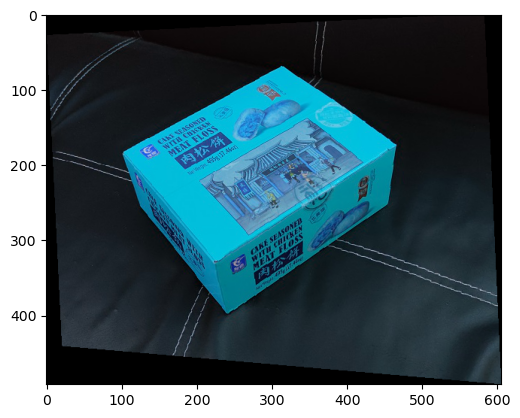

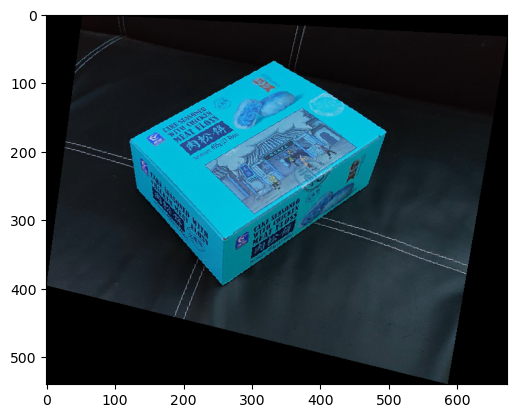

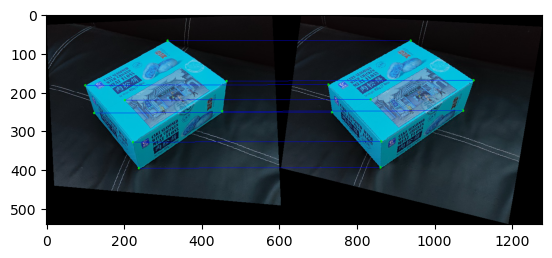

In [54]:
imgl = cv2.imread('1l.jpg')
imgr = cv2.imread('1r.jpg')

initial_coord_l = [[111,169], [240,317], [488,158], [346,55], [133,243], [253,385], [474,232], [223,207]]
initial_coord_r = [[112,190], [282,317], [478,134], [318,52], [134,263], [290,385], [466,208], [238,213]]

pts_l, Tl = pointsNormalization(initial_coord_l)
pts_r, Tr = pointsNormalization(initial_coord_r)
# print(pts_l)

initF = initialF(pts_l, pts_r, Tl, Tr)
# print(initF)
# print(np.linalg.matrix_rank(initF))

initCoord = [initial_coord_l, initial_coord_r]
F_refine = least_squares(costFunc, initF.flatten(), args = [initCoord], method = 'lm').x.reshape((3,3))
u,d,v = np.linalg.svd(F_refine)
d[-1] = 0
d_ = np.diag(d)
# d_ = np.array([[d[0],0,0], [0,d[1],0], [0,0,0]])
F_refine = np.dot(np.dot(u, d_), v)
F_refine = (F_refine/F_refine[-1])
# print(F_refine)
# print(np.linalg.matrix_rank(F_refine))

el, er = calcEpipoles(initF)
er_x = np.array([[0,-er[2],er[1]], [er[2],0,-er[0]], [-er[1],er[0],0]])

Pl = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
Pr = np.concatenate((np.dot(er_x, initF), np.reshape(er, (3,1))), axis = 1)
# print(Pl,Pr)


Hl, Hr = calcRectificationH(450, 600, pts_l, pts_r, el, er, Pl, Pr)


imgl_rec, offsetl = imageRecovery(imgl, np.linalg.inv(Hl))
print(offsetl)

plt.figure()
plt.imshow(imgl_rec)


imgr_rec, offsetr = imageRecovery(imgr, np.linalg.inv(Hr))
print(offsetr)

plt.figure()
plt.imshow(imgr_rec)

print(initial_coord_l)
ptsrecl = np.append(initial_coord_l, np.ones((len(initial_coord_l),1)), axis=1).T
ptsrecl = Hl.dot(ptsrecl)
ptsrecl = (ptsrecl/ptsrecl[-1]).T.astype(int)
ptsrecl[:,0] -= offsetl[0]
ptsrecl[:,1] -= offsetl[1]
print(ptsrecl)

print(initial_coord_r)
ptsrecr = np.append(initial_coord_r, np.ones((len(initial_coord_r),1)), axis=1).T
ptsrecr = np.dot(Hr, ptsrecr)
ptsrecr = (ptsrecr/ptsrecr[-1]).T.astype(int)
ptsrecr[:,0] -= offsetr[0]
ptsrecr[:,1] -= offsetr[1]
print(ptsrecr)

img_corr = drawCorrPoints(imgl_rec,imgr_rec,ptsrecl,ptsrecr)
plt.figure()
plt.imshow(img_corr)
cv2.imwrite('C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw9/result images/'+'test.jpg', img_corr)

cv2.imwrite('C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw9/result images/'+'lrect.jpg', imgl_rec)
cv2.imwrite('C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw9/result images/'+'rrect.jpg', imgr_rec)


# imgr_rec = imageRecovery(imgr, Hr)

# plt.figure()
# plt.imshow(imgr_rec)





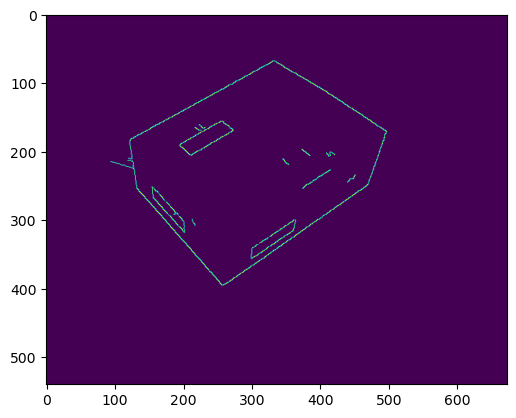

In [10]:
# edge extraction
grayl = cv2.cvtColor(imgl_rec, cv2.COLOR_BGR2GRAY)
grayl = cv2.blur(grayl, (3,3))
edgesl = cv2.Canny(grayl, 350, 200, 5)

# plt.imshow(edgesl)

grayr = cv2.cvtColor(imgr_rec, cv2.COLOR_BGR2GRAY)
grayr = cv2.blur(grayr, (3,3))
edgesr = cv2.Canny(grayr, 350, 200, 5)

# plt.imshow(edgesr)



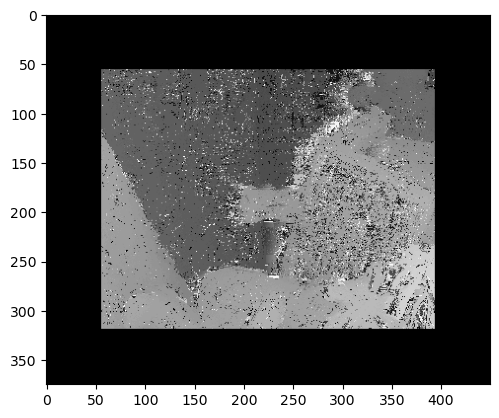

In [4]:
M = 9

imgl = cv2.imread('./Task3Images/im2.png')
imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2GRAY)
imgr = cv2.imread('./Task3Images/im6.png')
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)

gt = cv2.imread('./Task3Images/disp2.png')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
# print(gt)
gt = (gt.astype(np.float32)/4.0).astype(np.uint8)
# print(gt)

dmax = np.max(gt)
# print(dmax)

dmap = census(imgl, imgr, M, dmax)
        
        
dmap_img = (dmap/dmap.max()*255).astype(np.uint8)
dmap_img = cv2.cvtColor(dmap_img, cv2.COLOR_GRAY2RGB)

plt.figure()
plt.imshow(dmap_img)    





0.7700900168287421
(375, 450)


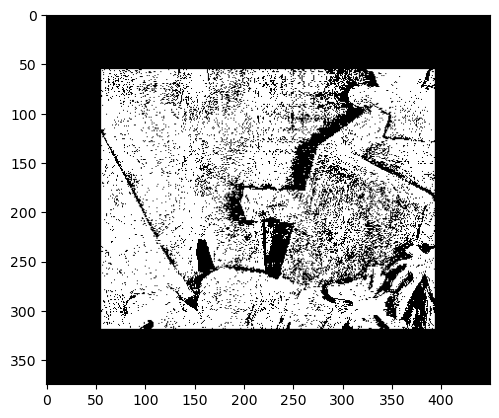

In [5]:
acc, errmask = disparityMapAcc(dmap, gt)

print(acc)
print(errmask.shape)

errmask = cv2.cvtColor(errmask*255, cv2.COLOR_GRAY2RGB)

plt.figure()
plt.imshow(errmask)    


In [16]:
print(initF.flatten())

[ 1.02279233e-06 -1.19342229e-05 -1.86751525e-03  8.38665132e-06
  2.16453438e-06 -3.14843566e-02 -1.64944776e-03  3.16891690e-02
  1.00000000e+00]
